## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [10]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [11]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [12]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


W1028 09:20:18.362262  1252 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1028 09:20:18.421735  1252 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Experiment with Regulizer = 0.010000


W1028 09:20:18.747760  1252 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W1028 09:20:19.222036  1252 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 159us/step - loss: 15.9532 - acc: 0.1974 - val_loss: 15.6293 - val_acc: 0.2542
Epoch 2/50
50000/50000 [==============================] - 6s 124us/step - loss: 15.3261 - acc: 0.2784 - val_loss: 15.0178 - val_acc: 0.3029
Epoch 3/50
50000/50000 [==============================] - 7s 139us/step - loss: 14.7380 - acc: 0.3180 - val_loss: 14.4562 - val_acc: 0.3327
Epoch 4/50
50000/50000 [==============================] - 8s 153us/step - loss: 14.1972 - acc: 0.3389 - val_loss: 13.9353 - val_acc: 0.3486
Epoch 5/50
50000/50000 [==============================] - 8s 160us/step - loss: 13.6926 - acc: 0.3524 - val_loss: 13.4453 - val_acc: 0.3649
Epoch 6/50
50000/50000 [==============================] - 8s 153us/step - loss: 13.2149 - acc: 0.3625 - val_loss: 12.9803 - val_acc: 0.3694
Epoch 7/50
50000/50000 [==============================] - 7s 145us/step - loss: 12.7594 - acc: 0.3689 - val_lo

50000/50000 [==============================] - 9s 178us/step - loss: 2.3594 - acc: 0.1881 - val_loss: 2.2493 - val_acc: 0.2545
Epoch 2/50
50000/50000 [==============================] - 9s 173us/step - loss: 2.1798 - acc: 0.2785 - val_loss: 2.1256 - val_acc: 0.2986
Epoch 3/50
50000/50000 [==============================] - 10s 209us/step - loss: 2.0857 - acc: 0.3165 - val_loss: 2.0549 - val_acc: 0.3318
Epoch 4/50
50000/50000 [==============================] - 10s 191us/step - loss: 2.0269 - acc: 0.3421 - val_loss: 2.0073 - val_acc: 0.3484
Epoch 5/50
50000/50000 [==============================] - 9s 173us/step - loss: 1.9828 - acc: 0.3562 - val_loss: 1.9690 - val_acc: 0.3616
Epoch 6/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.9486 - acc: 0.3685 - val_loss: 1.9377 - val_acc: 0.3740
Epoch 7/50
50000/50000 [==============================] - 9s 189us/step - loss: 1.9203 - acc: 0.3789 - val_loss: 1.9115 - val_acc: 0.3776
Epoch 8/50
50000/50000 [===================

50000/50000 [==============================] - 8s 165us/step - loss: 2.0258 - acc: 0.2979 - val_loss: 1.9600 - val_acc: 0.3154
Epoch 3/50
50000/50000 [==============================] - 8s 165us/step - loss: 1.9182 - acc: 0.3326 - val_loss: 1.8862 - val_acc: 0.3442
Epoch 4/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.8614 - acc: 0.3498 - val_loss: 1.8441 - val_acc: 0.3568
Epoch 5/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.8254 - acc: 0.3622 - val_loss: 1.8130 - val_acc: 0.3674
Epoch 6/50
50000/50000 [==============================] - 9s 171us/step - loss: 1.7975 - acc: 0.3729 - val_loss: 1.7868 - val_acc: 0.3746
Epoch 7/50
50000/50000 [==============================] - 8s 170us/step - loss: 1.7727 - acc: 0.3828 - val_loss: 1.7655 - val_acc: 0.3816
Epoch 8/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.7515 - acc: 0.3881 - val_loss: 1.7453 - val_acc: 0.3882
Epoch 9/50
50000/50000 [=====================

50000/50000 [==============================] - 7s 149us/step - loss: 1.9458 - acc: 0.3132 - val_loss: 1.9054 - val_acc: 0.3260
Epoch 4/50
50000/50000 [==============================] - 8s 152us/step - loss: 1.8747 - acc: 0.3445 - val_loss: 1.8500 - val_acc: 0.3508
Epoch 5/50
50000/50000 [==============================] - 8s 167us/step - loss: 1.8284 - acc: 0.3616 - val_loss: 1.8106 - val_acc: 0.3644
Epoch 6/50
50000/50000 [==============================] - 11s 213us/step - loss: 1.7938 - acc: 0.3740 - val_loss: 1.7789 - val_acc: 0.3769
Epoch 7/50
50000/50000 [==============================] - 10s 193us/step - loss: 1.7653 - acc: 0.3843 - val_loss: 1.7529 - val_acc: 0.3874
Epoch 8/50
50000/50000 [==============================] - 11s 227us/step - loss: 1.7422 - acc: 0.3937 - val_loss: 1.7317 - val_acc: 0.3961
Epoch 9/50
50000/50000 [==============================] - 11s 227us/step - loss: 1.7213 - acc: 0.4009 - val_loss: 1.7144 - val_acc: 0.4059
Epoch 10/50
50000/50000 [================

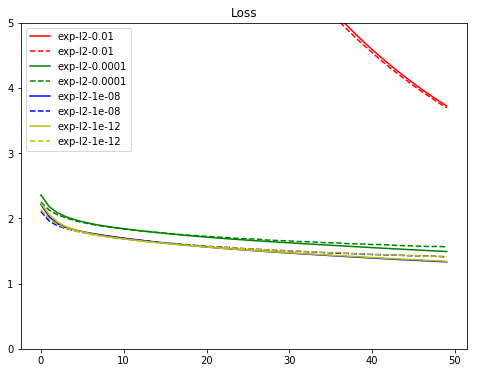

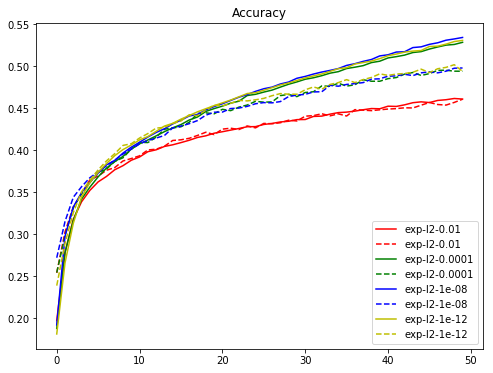

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()